In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_table('../data/u.data')
data.head()

,user,event,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Pre-processing the data

#### 3.1 Finding all unique values from data for events and users

In [ ]:
users = data['user'].unique()
events = data['event'].unique()

events[:10], users[:10]

(array([242, 302, 377,  51, 346, 474, 265, 465, 451,  86]),
 array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6]))

#### 3.2 Assigning idx's to unique users and events

In [ ]:
user_to_idx = {user: idx for idx, user in enumerate(users)}
event_to_idx = {event: idx for idx, event in enumerate(events)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()} # For reverse lookup
idx_to_event = {idx: event for event, idx in event_to_idx.items()} # For reverse lookup

for key, value in user_to_idx.items():
    if value == 0:
        print(f'User: {key}, assigned index: {value}')

for key, value in event_to_idx.items():
    if value == 0:
        print(f'Event: {key}, assigned index: {value}')

User: 196, assigned index: 0
Event: 242, assigned index: 0


#### 3.3 Using the idx to add column in dataframe

In [ ]:
data['user_idx'] = data['user'].map(user_to_idx)
data['event_idx'] = data['event'].map(event_to_idx)

data.head()

,user,event,rating,timestamp,user_idx,event_idx
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


#### 3.4 Splitting the data into training and testing

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=21, shuffle=True)
len(train_data), len(val_data), len(test_data)

(60000, 20000, 20000)

#### 3.5 Creating the train and test dataloaders

In [ ]:
train_dataloader = DataLoader(train_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [ ]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=96, hidden_dim=64):
        super(NCF, self).__init__()
        self.user_autoencoder = Autoencoder(num_users, embedding_dim)
        self.item_autoencoder = Autoencoder(num_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, user, item):
        user_onehot = F.one_hot(user, num_classes=self.user_autoencoder.encoder[0].in_features).float()
        item_onehot = F.one_hot(item, num_classes=self.item_autoencoder.encoder[0].in_features).float()
        
        user_embedded, _ = self.user_autoencoder(user_onehot)
        item_embedded, _ = self.item_autoencoder(item_onehot)
        
        x = torch.cat([user_embedded, item_embedded], dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_autoencoder(autoencoder, dataloader, num_epochs=10, lr=1e-3):
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            _, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=10):
    model.train()
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    l2_lambda = 1e-4

    train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse = [], [], [], [], [], []

    for epoch in range(num_epochs):
        total_loss = 0
        total_val_loss = 0
        total_train_mae = 0
        total_val_mae = 0
        total_train_rmse = 0
        total_val_rmse = 0

        for batch in train_dataloader:
            user, item, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            optimizer.zero_grad()
            output = model(user, item).squeeze()
            loss = criterion(output, target) + l2_lambda * (model.fc1.weight.norm() + model.fc2.weight.norm())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            total_train_mae += torch.abs(output - target).mean().item()
            total_train_rmse += torch.sqrt(torch.mean((output - target) ** 2)).item()

        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                user, item, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
                output = model(user, item).squeeze()
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

                total_val_mae += torch.abs(output - target).mean().item()
                total_val_rmse += torch.sqrt(torch.mean((output - target) ** 2)).item()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_train_mae = total_train_mae / len(train_dataloader)
        avg_val_mae = total_val_mae / len(val_dataloader)
        avg_train_rmse = total_train_rmse / len(train_dataloader)
        avg_val_rmse = total_val_rmse / len(val_dataloader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_mae.append(avg_train_mae)
        val_mae.append(avg_val_mae)
        train_rmse.append(avg_train_rmse)
        val_rmse.append(avg_val_rmse)

        if early_stopper.early_stop(avg_val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f'Epoch: {epoch+1} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train MAE: {avg_train_mae:.4f} | Val MAE: {avg_val_mae:.4f} | Train RMSE: {avg_train_rmse:.4f} | Val RMSE: {avg_val_rmse:.4f}')

    return train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_users = len(users)
num_items = len(events)
embedding_dim = 96

In [ ]:
user_autoencoder = Autoencoder(num_users, embedding_dim).to(device)
item_autoencoder = Autoencoder(num_items, embedding_dim).to(device)

user_dataloader = DataLoader(torch.eye(num_users).to(device), batch_size=64, shuffle=True)
item_dataloader = DataLoader(torch.eye(num_items).to(device), batch_size=64, shuffle=True)

In [ ]:
print("Training User Autoencoder:")
train_autoencoder(user_autoencoder, user_dataloader)
print("\nTraining Item Autoencoder:")
train_autoencoder(item_autoencoder, item_dataloader)

Training User Autoencoder:
Epoch 1/10, Loss: 0.0023194567610820135
Epoch 2/10, Loss: 0.0011412668041884898
Epoch 3/10, Loss: 0.0010762024748449525
Epoch 4/10, Loss: 0.0010598533243561783
Epoch 5/10, Loss: 0.0010548903374001384
Epoch 6/10, Loss: 0.0010518170427531004
Epoch 7/10, Loss: 0.0010491991338009636
Epoch 8/10, Loss: 0.0010466828399027387
Epoch 9/10, Loss: 0.001043823299308618
Epoch 10/10, Loss: 0.0010410123815139136

Training Item Autoencoder:
Epoch 1/10, Loss: 0.0014418758305341558
Epoch 2/10, Loss: 0.0006119534610425708
Epoch 3/10, Loss: 0.0005953932737207247
Epoch 4/10, Loss: 0.0005933003181039736
Epoch 5/10, Loss: 0.0005922730800833691
Epoch 6/10, Loss: 0.0005913278135402059
Epoch 7/10, Loss: 0.000590417156841054
Epoch 8/10, Loss: 0.0005895959739400833
Epoch 9/10, Loss: 0.0005885995363954593
Epoch 10/10, Loss: 0.0005876977100140519


In [ ]:
model = NCF(num_users, num_items, embedding_dim).to(device)
model.user_autoencoder.load_state_dict(user_autoencoder.state_dict())
model.item_autoencoder.load_state_dict(item_autoencoder.state_dict())

<All keys matched successfully>

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses, train_mae, val_mae, train_rmse, val_rmse = train(
    model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=10
)

Epoch: 1 -> Train Loss: 1.2822 | Val Loss: 0.9388 | Train MAE: 0.8629 | Val MAE: 0.7607 | Train RMSE: 1.0600 | Val RMSE: 0.9645
Epoch: 2 -> Train Loss: 0.9089 | Val Loss: 0.9187 | Train MAE: 0.7576 | Val MAE: 0.7663 | Train RMSE: 0.9489 | Val RMSE: 0.9549
Epoch: 3 -> Train Loss: 0.8944 | Val Loss: 0.9314 | Train MAE: 0.7507 | Val MAE: 0.7783 | Train RMSE: 0.9413 | Val RMSE: 0.9618
Epoch: 4 -> Train Loss: 0.8835 | Val Loss: 0.9152 | Train MAE: 0.7457 | Val MAE: 0.7500 | Train RMSE: 0.9359 | Val RMSE: 0.9522
Epoch: 5 -> Train Loss: 0.8793 | Val Loss: 0.9091 | Train MAE: 0.7430 | Val MAE: 0.7623 | Train RMSE: 0.9335 | Val RMSE: 0.9499
Epoch: 6 -> Train Loss: 0.8773 | Val Loss: 0.9041 | Train MAE: 0.7419 | Val MAE: 0.7539 | Train RMSE: 0.9323 | Val RMSE: 0.9470
Epoch: 7 -> Train Loss: 0.8745 | Val Loss: 0.9009 | Train MAE: 0.7409 | Val MAE: 0.7496 | Train RMSE: 0.9309 | Val RMSE: 0.9452
Epoch: 8 -> Train Loss: 0.8707 | Val Loss: 0.9019 | Train MAE: 0.7386 | Val MAE: 0.7535 | Train RMSE: 0.

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_mae = 0
    total_rmse = 0
    with torch.no_grad():
        for batch in dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()
            total_mae += torch.abs(output - target).mean().item()
            total_rmse += torch.sqrt(torch.mean((output - target) ** 2)).item()

    avg_loss = total_loss / len(dataloader)
    avg_mae = total_mae / len(dataloader)
    avg_rmse = total_rmse / len(dataloader)
    return avg_loss, avg_mae, avg_rmse

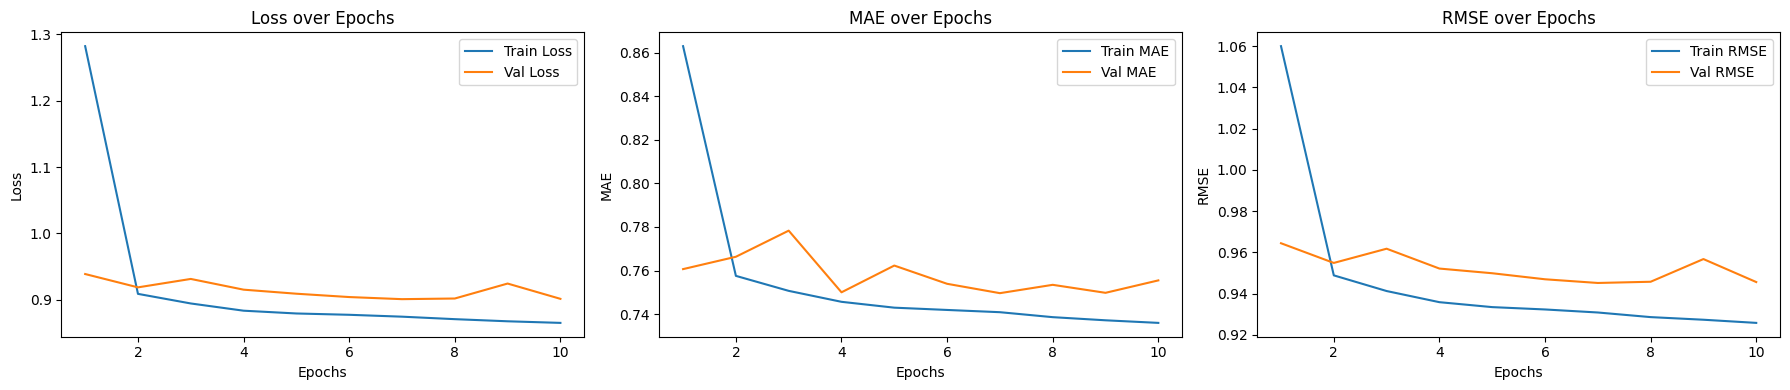

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses,  label='Train Loss')
plt.plot(epochs, val_losses,  label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae,  label='Train MAE')
plt.plot(epochs, val_mae,  label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse,  label='Train RMSE')
plt.plot(epochs, val_rmse,  label='Val RMSE')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_mae, test_rmse = evaluate(model, test_dataloader, device)
print(f"\nTest Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f}")


Test Loss: 0.8964 | Test MAE: 0.7531 | Test RMSE: 0.9429
